# PINN learning of Schrodinger Equation

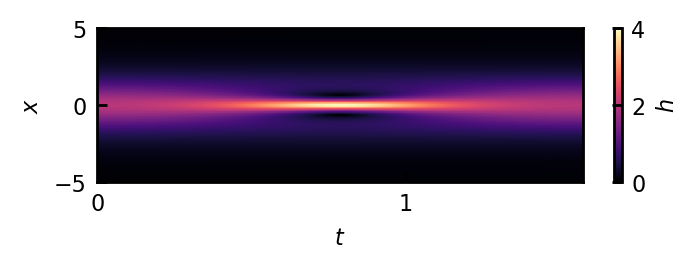

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, '../src')

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

plt.style.use('../../figure_style.mplstyle')

# Load data
data = loadmat('../data/NLS.mat')
U_star = data['uu']
t_star = data['tt'].T
x_star = data['x'].T

N = x_star.shape[0]
T = t_star.shape[0]

# Reshape data
XX = np.tile(x_star[:,0:1], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

x = XX.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1
u = U_star.flatten()[:,None] # NT x 1

# Plot data
def plot_field(ax, u, vmin, vmax, label=None):
    umag = np.sqrt(u.real**2 + u.imag**2)
    im = ax.pcolormesh(TT, XX, umag, cmap='magma', vmin=vmin, vmax=vmax)
    ax.set(xlabel='$t$', xticks=[0, 1],
           ylabel='$x$', ylim=[-5,5], yticks=[-5, 0, 5],
           aspect=0.05)
    plt.colorbar(im, ax=ax, label=label)

fig, ax = plt.subplots(1,1, figsize=(4,1))
plot_field(ax, U_star, vmin=0, vmax=4, label='$h$')

# Solve a Boundary Value Problem

$$ i h_t + 0.5 h_{xx} + |h|^2 h = 0 $$

$$ h(0, x) = 2 sech(x) $$

$$ h(t, -5) = h(t, 5) $$

$$ h_x (t, -5) = h_x(t, 5) $$


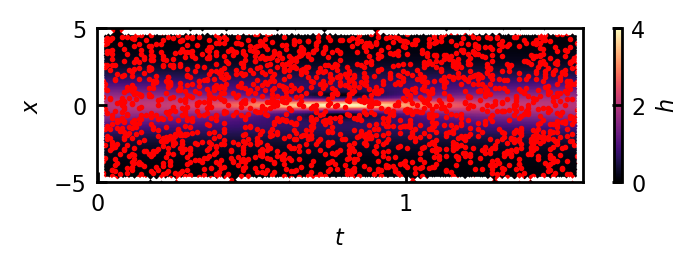

In [2]:
# Select points for bulk physics-informed loss
N_f = 2000
idx = np.random.choice(N*T, N_f, replace=False)
x_f, t_f, u_f = x[idx,:], t[idx,:], u[idx,:]

# Select boundary points for reconstruction loss
N_u = 500
idxs = np.argwhere(np.logical_or(
    np.logical_or(x == x.min(), x == x.max()),
    np.logical_or(t == t.min(), t == t.max())
))[:, 0]
idx = np.random.choice(idxs, N_u, replace=False)
x_b, t_b, u_b = x[idx,:], t[idx,:], u[idx,:]

# Plot both sets of points
fig, ax = plt.subplots(1,1, figsize=(4,1))
plot_field(ax, U_star, vmin=0, vmax=4, label='$h$')
ax.scatter(t_f, x_f, c='red', s=1)
ax.scatter(t_b, x_b, c='white', marker='x', s=10)

In [3]:
import torch
from schrodinger_pinn import SchrodingerBVPPINN

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Starting to train on device {device}')

model = SchrodingerBVPPINN(
    data=dict(
        x_f=x_f,
        t_f=t_f,
        x_b=x_b,
        t_b=t_b,
        u_b=u_b
    ),
).to(device)
model.train(50000)

Starting to train on device cuda:0
Iteration 1000, Loss: 7.01915e-02, MSE: 5.97834e-02, Phys: 1.04081e-02
Iteration 2000, Loss: 6.97098e-02, MSE: 5.93600e-02, Phys: 1.03498e-02
Iteration 3000, Loss: 6.95673e-02, MSE: 5.91385e-02, Phys: 1.04289e-02
Iteration 4000, Loss: 6.94282e-02, MSE: 5.88636e-02, Phys: 1.05646e-02
Iteration 5000, Loss: 5.29958e-02, MSE: 4.09155e-02, Phys: 1.20803e-02
Iteration 6000, Loss: 4.28196e-02, MSE: 3.44783e-02, Phys: 8.34125e-03
Iteration 7000, Loss: 3.83421e-02, MSE: 3.05547e-02, Phys: 7.78737e-03
Iteration 8000, Loss: 3.31394e-02, MSE: 2.60285e-02, Phys: 7.11089e-03
Iteration 9000, Loss: 3.04257e-02, MSE: 2.34694e-02, Phys: 6.95628e-03
Iteration 10000, Loss: 2.77771e-02, MSE: 2.08200e-02, Phys: 6.95715e-03
Iteration 11000, Loss: 2.60109e-02, MSE: 1.87534e-02, Phys: 7.25744e-03
Iteration 12000, Loss: 2.29217e-02, MSE: 1.66590e-02, Phys: 6.26265e-03
Iteration 13000, Loss: 1.99374e-02, MSE: 1.41886e-02, Phys: 5.74885e-03
Iteration 14000, Loss: 1.71662e-02, MS

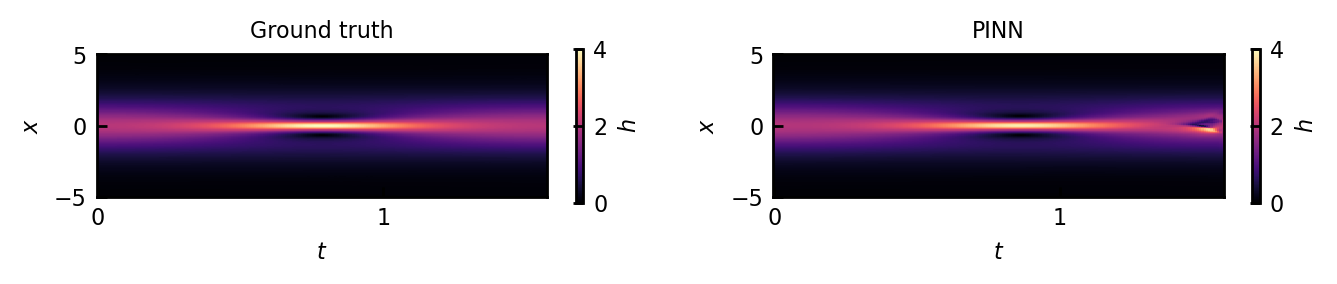

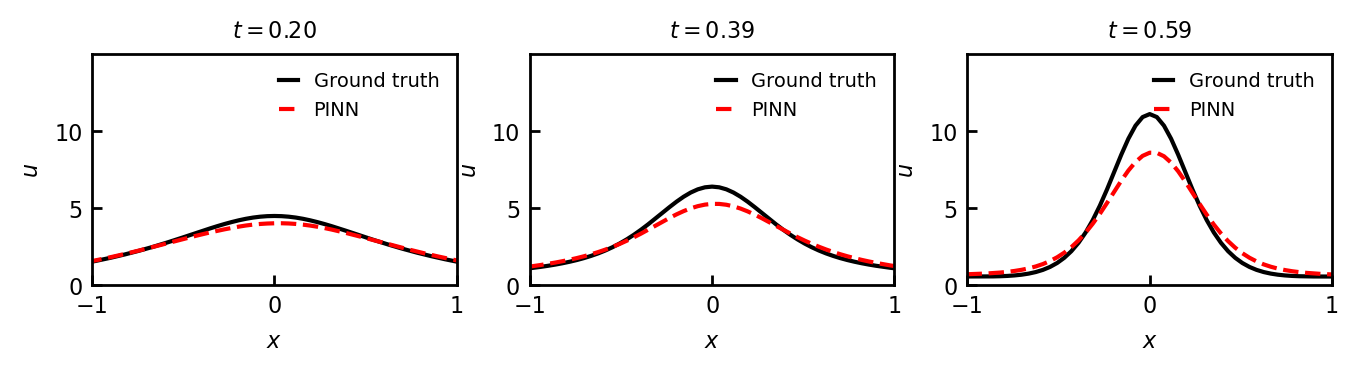

In [4]:
fig, ax = plt.subplots(1,2, figsize=(8,1))
plot_field(ax[0], U_star, vmin=0, vmax=4, label='$h$')
ax[0].set_title('Ground truth')

xt = torch.FloatTensor(np.concatenate([x, t], axis=-1)).to(device)
H_pred = model(xt).detach().cpu().numpy()
U_pred = np.empty(H_pred.shape[:-1], dtype=np.complex128)
U_pred.real = H_pred[..., 0]
U_pred.imag = H_pred[..., 1]
U_pred = U_pred.reshape(U_star.shape)
plot_field(ax[1], U_pred, vmin=0, vmax=4, label='$h$')
ax[1].set_title('PINN')

fig, ax = plt.subplots(1, 3, figsize=(8, 1.5))

UA_star = U_star.real**2 + U_star.imag**2
UA_pred = U_pred.real**2 + U_pred.imag**2
ax[0].plot(x_star, UA_star[:,25], color='black', label='Ground truth')
ax[1].plot(x_star, UA_star[:,50], color='black', label='Ground truth')
ax[2].plot(x_star, UA_star[:,75], color='black', label='Ground truth')

ax[0].plot(x_star, UA_pred[:,25], color='red', linestyle='--', label='PINN')
ax[1].plot(x_star, UA_pred[:,50], color='red', linestyle='--', label='PINN')
ax[2].plot(x_star, UA_pred[:,75], color='red', linestyle='--', label='PINN')

ax[0].set_title(f'$t = {t_star[25,0]:.2f}$')
ax[1].set_title(f'$t = {t_star[50,0]:.2f}$')
ax[2].set_title(f'$t = {t_star[75,0]:.2f}$')

for a in ax:
    a.set(xlabel='$x$', xlim=[-1, 1], xticks=[-1, 0, 1], 
          ylabel='$u$', ylim=[0, 15], yticks=[0, 5, 10])
    a.legend()